<a href="https://colab.research.google.com/github/PHMark/ML-Personal-Projects/blob/master/e-commerce-recommender-system/E_commerce_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Amazon Ladies Apparel Recommendations </h1>



In [127]:
import requests
import os
from io import BytesIO
import itertools


from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

In [128]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [84]:
# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

% matplotlib inline

In [85]:
CURRENT_DIR = os.path.abspath(os.curdir)
DATA_DIR = os.path.join(CURRENT_DIR, "drive/My Drive/ML Projects/E-commerce Recommender System/data")
FILE_DIR = os.path.join(DATA_DIR, "2020-08-28-ladies-apparel-tops.json")

In [86]:
df = pd.read_json(FILE_DIR)

In [87]:
print("Total Number of Data Points: {}\nTotal Number of Features: {}".format(*df.shape))

Total Number of Data Points: 183138
Total Number of Features: 19


In [88]:
print(df.columns)

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')


Because of limited computational resource, and also to iterate on things much faster, we will be using only 6 features namely:

1. **asin** - Amazon standard identification number.

2. **brand** - Brand to which the product belongs to.

3. **color** Color information of apparel, it can contain many colors as a value *ex: red and black stripes*.

4. **product_type_name** - Type of the apperal, *ex: SHIRT/TSHIRT*.

5. **medium_image_url** - URL of the image.

6. **title** - title of the product.

7. **formatted_price** - price of the product.


Since I will use NLP techniques,
these features are relevant for my current use case. Also, intuitively, these metadata gives so much information to describe a product in an e-commerce shop.


In [89]:
df = df[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [90]:
df.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


# 1.) Feature Analysis

The amazon dataset contains 183138 rows, i.e., womens tops, and 19 features. 

**We will analyse the dataset to identify:**

1. Missing values
2. High Level Statistics of each Feature.
3. Check for duplicated data points / products.

## 1.1 Missing Values

Garbage-In-Garbage-Out.

Checking for missing values is an important part of data analysis. Ideally in machine learning, we want to transform our data to be an edible information for our computer to process.

In [91]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in df.columns if df[var].isnull().sum() > 1]

# print the variable name and the percentage of missing values
for var in vars_with_na:
    print(var, np.round(df[var].isnull().mean(), 3),  ' % missing values')

brand 0.001  % missing values
color 0.645  % missing values
formatted_price 0.845  % missing values


Our dataset contains 3 variables with missing values. We need to account for this in our data preprocessing section.

## 1.2 High Level Statistics

In [92]:
def show_feature_statistics(data: pd.Series, n: int, variable_name: str):
  print("Basic Statistics for the {} variable:".format(variable_name))
  print("="*75)
  print(data.describe())
  print("="*75)
  print("\nUnique Values:")
  print(data.unique())
  print("="*75)

  _frequency = data.value_counts()
  plt.figure(figsize=(10, 6))
  plt.title("Top {} most frequent values in the {} variable".format(n, variable_name))
  plt.xlabel("Category Levels")
  plt.ylabel("Frequency")
  _frequency.head(n).plot(kind='bar', color="orange")
  plt.show()

#### 1.2.1 For product_type_name variable

Basic Statistics for the product_type_name variable:
count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object

Unique Values:
['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECO

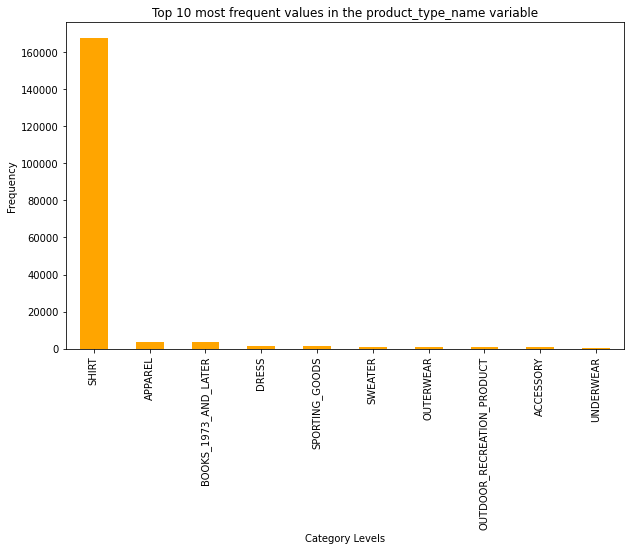

In [93]:
show_feature_statistics(data=df["product_type_name"], n=10, variable_name="product_type_name")

We have a total of 72 unique type of product_type_names, and the most frequent category was "SHIRT".

In [94]:
def plot_wordcloud(data: pd.Series):
  data = data.copy().value_counts()
  data = data.to_dict()
  wordcloud = (WordCloud(background_color='grey', width=640, height=480)
                .generate_from_frequencies(data))
  plt.figure(figsize=(30, 10))
  plt.imshow(wordcloud)
  plt.axis(False)
  plt.show()

#### 1.2.2 For brand variable

Basic Statistics for the brand variable:
count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object

Unique Values:
['FNC7C' 'FIG Clothing' 'Focal18' ... 'Z' "Rain's Pan Jacket"
 'FFLMYUHULIU']


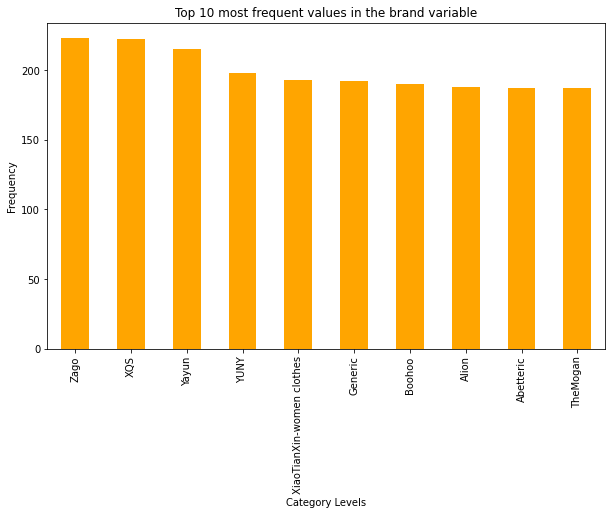

In [95]:
show_feature_statistics(data=df["brand"], n=10, variable_name="brand")

#### 1.2.3 For color variable

Basic Statistics for the color variable:
count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object

Unique Values:
[None 'Onyx Black/ Stone' 'Grape' ... 'Combo C'
 'White, Soft Coral and Charcoal Varigated' 'Monochrome Plaid']


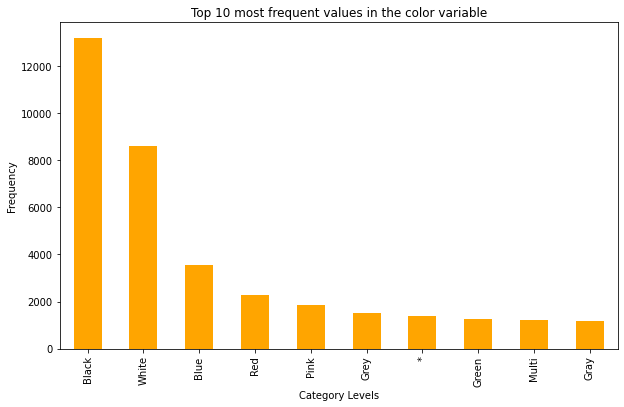

In [96]:
show_feature_statistics(data=df["color"], n=10, variable_name="color")

#### 1.2.4 For formatted_price variable

Basic Statistics for the formatted_price variable:
count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object

Unique Values:
[None '$26.26' '$9.99' ... '$16.05' '$88.29' '$28.05']


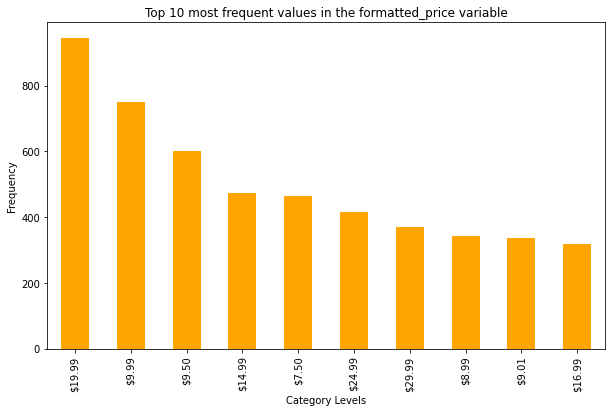

In [97]:
show_feature_statistics(data=df["formatted_price"], n=10, variable_name="formatted_price")

#### 1.2.5 For title variable

Basic Statistics for the title variable:
count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object

Unique Values:
['Minions Como Superheroes Ironman Long Sleeve Round Neck T-Shirt For Women'
 'FIG Clothing Womens Izo Tunic' 'FIG Clothing Womens Won Top' ...
 'Wrangler George Strait For Her Long Sleeve Pink Print Western Shirt'
 'Susana Monaco Womens Susana Monoco Sleeveless Smock Top, 6, Pink'
 "SexyBaby Women's Mesh Splive Flounced Sleeve Crew Neck Tops Blouses"]


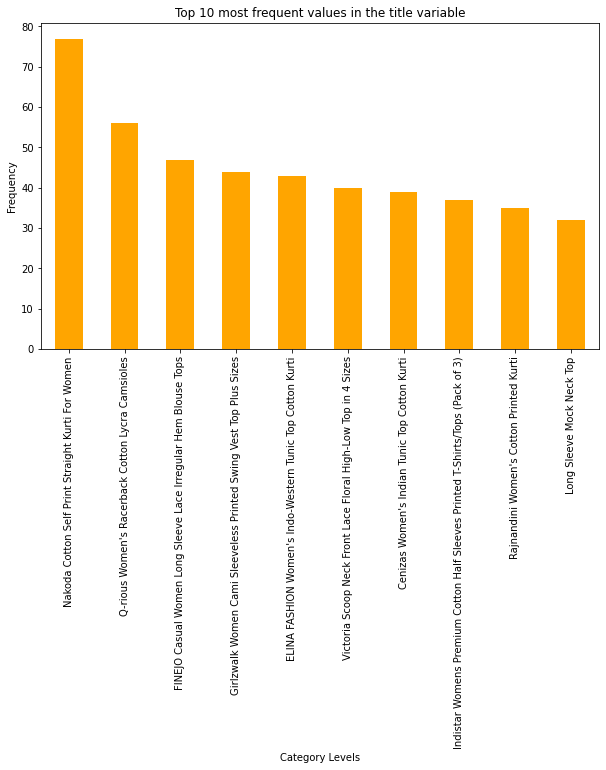

In [98]:
show_feature_statistics(data=df["title"], n=10, variable_name="title")

### 1.3 Check for duplicated data points

In [99]:
print(f"There are {sum(df.duplicated('title'))} products which have the same title.")

There are 7153 products which have the same title.


#### 1.3.1 Visualizing Duplicates

We can visualize duplicate products using the medium_image_url variable.

In [100]:
def get_image(url):
  response = requests.get(url, stream=True)
  img = Image.open(response.raw)
  # img.save('images/28k_images/'+row['asin']+'.jpeg')
  return img

In [101]:
df_sorted = df[df.duplicated('title')].sort_values('title', ascending=True)
df_sorted.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
13389,B01GGKMTEW,Acting Pro,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,"""Tonight is Bottoms Up"" Scoop Neck Racerback T...",None
114281,B01LWSP7G2,Faithful Findings,Gray,https://images-na.ssl-images-amazon.com/images...,SHIRT,"#Hope, Women's Jr Size Tee, Religious, Faith-I...",None
132703,B01LXRRR0B,Faithful Findings,Gray,https://images-na.ssl-images-amazon.com/images...,SHIRT,"#Love, Women's Jr Size Tee, Religious, Faith-I...",None
105741,B00UUEQC6M,GLJ TRADING,B318 SD_BLACK,https://images-na.ssl-images-amazon.com/images...,SHIRT,(Plus Size) Cutout Crochet Lined Tunic with Ch...,$31.99
104836,B018RR1QNW,GLJ TRADING,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,(Plus Size) Long Sleeves Crew Neck Hi-Lo Hem K...,None


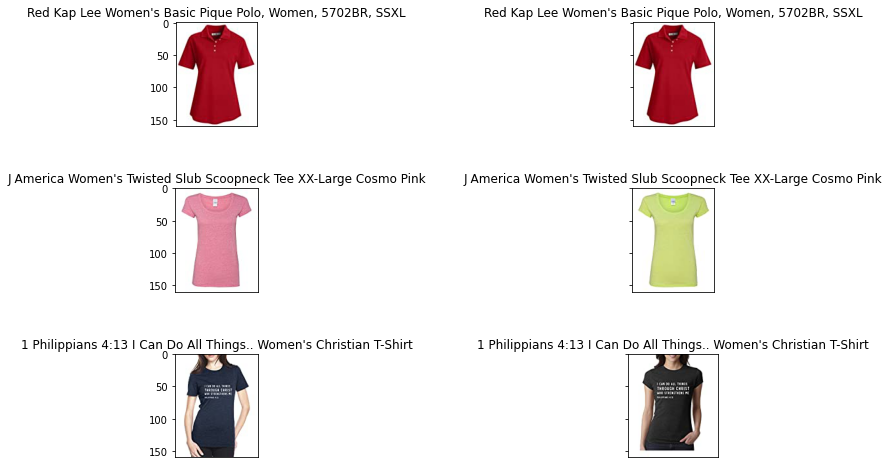

In [102]:
duplicated_asins = ["B00AQ4GMCK", "B00G278Z2A", "B074SYFP2W", "B074SRT6LV", "B00AQ4GN3I", "B00G278W6O"]
images_to_visualize = df.loc[df["asin"].isin(duplicated_asins), ["title", "medium_image_url"]].values
fig, axes = plt.subplots(3, 2, figsize=(15, 8), sharey=True)
plt.subplots_adjust(hspace=0.6)
for ax, title, url in zip(axes, images_to_visualize.T[0].reshape(3, 2), images_to_visualize.T[1].reshape(3, 2)):
  img1, img2 = get_image(url[0]), get_image(url[1])
  ax[0].imshow(img1)
  ax[0].set_title(title[0])
  ax[0].set_xticks([])
  ax[1].imshow(img2)
  ax[1].set_title(title[0])
  ax[1].set_xticks([])
plt.show()

Since we will use the title variable to find similar products, and generally speaking, removing duplicates will help us improve the performance of our algorithm.

## 2.) Data Cleaning

### 2.1 Removing Missing Values

I am not a fan of removing missing values, but since I wanted to iteraterate quickly and see if my chosen features would work, I will remove all of the data points w.r.t color and formatted_price variables' missing values. Thus, will decrease the amount of data that we are going to process. But ideally, we should impute those missing values (ie. mean/median imputation, predictive based imputation. In color, we can use image processing to help us identify the corresponding color of the product).

In [103]:
df = df.loc[~df['formatted_price'].isnull()]

In [104]:
df =df.loc[~df['color'].isnull()]

In [105]:
df.shape

(28385, 7)

In [106]:
df.shape

(28385, 7)

### 2.2 Removing Products with Few Words in the Title

Short titles doesn't give us much information about the product, so I decided to remove all products with title length less than equal to 5.

In [107]:
df_sorted = df[df['title'].apply(lambda x: len(x.split()) > 4)]

In [108]:
df_sorted.shape

(27949, 7)

In [109]:
df_sorted.sort_values('title', inplace=True, ascending=False)
df_sorted.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
61973,B06Y1KZ2WB,Éclair,Black/Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Éclair Women's Printed Thin Strap Blouse Black...,$24.99
133820,B010RV33VE,xiaoming,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19
81461,B01DDSDLNS,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Women's White Long Sleeve Single Brea...,$21.58
75995,B00X5LYO9Y,xiaoming,Red Anchors,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91
151570,B00WPJG35K,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32


### 2.3 Deduplication

In [113]:
indices = df_sorted.index.tolist()

stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = df_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = df['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = df['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(df_sorted['asin'].loc[indices[i]])


            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [114]:
df = df.loc[df['asin'].isin(stage1_dedupe_asins)]

In [115]:
print('Number of data points : ', df.shape[0])

Number of data points :  17592


In [ ]:
indices = df.index.tolist()
stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(df['asin'].loc[i])
    # consider the first apperal's title
    a = df['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = df['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [ ]:
df = df.loc[df['asin'].isin(stage2_dedupe_asins)]

In [117]:
print('Number of data points after stage two of dedupe: ', data.shape[0])
# from 17k apparels we reduced to 16k apparels

Number of data points after stage two of dedupe:  16042


In [119]:
df.to_pickle(os.path.join(DATA_DIR, '16k_reduced_data'))

## 3.) Text Preprocessing

In [120]:
df = pd.read_pickle(os.path.join(DATA_DIR, '16k_reduced_data'))

In [131]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        return string

list of stop words: {'s', 'how', 'mightn', 'those', 'ain', 'under', 'yourself', 'until', 'me', 'with', 'some', 'i', 'who', 'off', 'he', 'doesn', "that'll", 'now', 'y', 'hadn', 'which', "isn't", 'him', 'have', 'you', "aren't", 'but', 'than', 'needn', 'they', 'for', 'doing', 'too', 'hers', 'd', 'no', 'was', 'against', 'or', 'himself', 'weren', 'where', 'there', 'were', 'through', "she's", 'our', 'if', 'haven', 'be', 'didn', 'wouldn', 'as', "wouldn't", 'are', "hadn't", 'up', 'can', 'other', 'very', 'itself', 'my', 'did', 'nor', 'will', 'further', 'isn', "hasn't", 'out', 'on', 'few', 'mustn', 'ours', 'over', "haven't", 'more', 'been', 'these', 'when', 'from', 'll', 'having', 't', "wasn't", 'below', "you've", 'ourselves', 'because', 'then', 'again', "won't", 'theirs', "shan't", "should've", 'what', 'wasn', 'themselves', "you'd", "couldn't", 'during', 'just', 'myself', 'above', 'to', 'his', 'before', 'her', 'both', 'couldn', 'while', 've', 'own', "needn't", 'not', 'your', "weren't", 'so', 'a

In [132]:
df["title"] = df["title"].apply(nlp_preprocessing)

In [133]:
df.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95
